<a href="https://colab.research.google.com/github/niobeus/seedings/blob/main/seedings_train_val_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Detectron2

In [ ]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

     |████████████████████████████████| 276kB 25.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=159cc3b81e1b943b79d6b46716965195721d8f2f0375b5b752a3e7ba12aa0820
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 635kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=53575cba0de52a806700932f06c5db8a1778df4b498da15983edd367ea33af44
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/'

Mounted at /content/drive


Load images and register dataset

In [ ]:
register_coco_instances("seedings_train", {},
                        path+"labelme/masks_coco/train/annotation.json",
                        path+"labelme/masks")
register_coco_instances("seedings_val", {},
                        path+"labelme/masks_coco/val/annotation.json",
                        path+"labelme/masks")
register_coco_instances("seedings_test", {},
                        path+"labelme/masks_coco/test/annotation.json",
                        path+"labelme/masks")

In [ ]:
# train
seedlings_metadata = MetadataCatalog.get("seedings_train")
dataset_dicts = DatasetCatalog.get("seedings_train")
# val
seedlings_metadata_val = MetadataCatalog.get("seedings_val")
dataset_dicts_val = DatasetCatalog.get("seedings_val")
# test
seedlings_metadata_test = MetadataCatalog.get("seedings_test")
dataset_dicts_test = DatasetCatalog.get("seedings_test")

[06/03 03:00:12 d2.data.datasets.coco]: Loading /content/drive/MyDrive/labelme/masks_coco/train/annotation.json takes 1.09 seconds.
[06/03 03:00:12 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/drive/MyDrive/labelme/masks_coco/train/annotation.json
[06/03 03:00:12 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/drive/MyDrive/labelme/masks_coco/val/annotation.json
[06/03 03:00:12 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/drive/MyDrive/labelme/masks_coco/test/annotation.json


In [ ]:
seedlings_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/labelme/masks', json_file='/content/drive/MyDrive/labelme/masks_coco/train/annotation.json', name='seedings_train', thing_classes=['1'], thing_dataset_id_to_contiguous_id={1: 0})

In [ ]:
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15, 15)

In [ ]:
# d = random.sample(dataset_dicts, 1)[0]
# img = cv2.imread(d["file_name"])
# visualizer = Visualizer(img[:, :, ::-1], metadata=seedlings_metadata, scale=0.5)
# vis = visualizer.draw_dataset_dict(d)
# plt.imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("seedings_train",)
cfg.DATASETS.TEST = ("seedings_test",) 
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 600
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "./output_seedlings"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/03 03:22:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[06/03 03:22:38 d2.engine.train_loop]: Starting training from iteration 0
[06/03 03:23:00 d2.utils.events]:  eta: 0:10:34  iter: 19  total_loss: 2.478  loss_cls: 0.6432  loss_box_reg: 0.8032  loss_mask: 0.6818  loss_rpn_cls: 0.106  loss_rpn_loc: 0.2237  time: 1.1103  data_time: 0.6329  lr: 0.00019981  max_mem: 6695M
[06/03 03:23:22 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/drive/MyDrive/labelme/masks_coco/test/annotation.json
[06/03 03:23:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/03 03:23:22 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[06/03 03:23:22 d2.data.common]: Serialized dataset takes 0.04 MiB
WARNING [06/03 03:23:22 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/03 03:23:22 d2.eva

In [ ]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

model = build_model(cfg)

# DetectionCheckpointer(model).load(file_path_or_url)  # load a file, usually from cfg.MODEL.WEIGHTS

checkpointer = DetectionCheckpointer(model, save_dir=path)
checkpointer.save("model_final")  # save to output

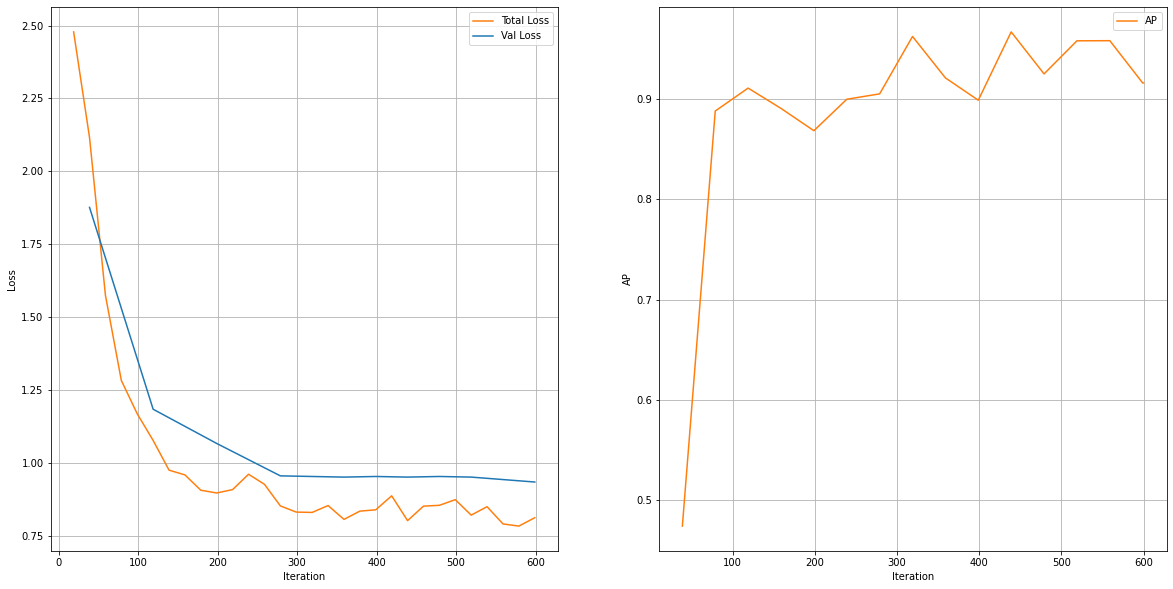

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output_seedlings'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

# результаты в файл metrics.json не перезаписываются, а добавляются
# поэтому если перезапускать модель, могут появиться некоторые странности
experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

fig, ax = plt.subplots(1,2, figsize=(20,10))

color1 = 'tab:orange'
color2 = 'tab:blue'

ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')

ax[0].plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], color=color1, label="Total Loss")
ax[0].plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], color=color2, label="Val Loss")
    
ax[0].tick_params(axis='y')
ax[0].grid(True)
ax[0].legend(loc='upper right')

ax[1].set_ylabel('AP')
ax[1].set_xlabel('Iteration')
ax[1].plot(
    [x['iteration'] for x in experiment_metrics if 'segm/AP' in x], 
    [x['segm/AP50']/100 for x in experiment_metrics if 'segm/AP' in x], color=color1, label="AP")
ax[1].tick_params(axis='y')
ax[1].grid(True)
ax[1].legend(loc='upper right')

# ax[2].set_ylabel('AR')
# ax[2].set_xlabel('Iteration')
# ax[2].plot(
#     [x['iteration'] for x in experiment_metrics if 'segm/AR' in x], 
#     [x['segm/AR'] for x in experiment_metrics if 'segm/AR' in x], color=color2, label="AR")
# ax[2].tick_params(axis='y')
# ax[2].legend(loc='upper right')

plt.show()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./output_seedlings

In [ ]:
# evaluator = COCOEvaluator("seedings_val", ("bbox", "segm"), False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "seedings_val")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))

In [ ]:
evaluator = COCOEvaluator("seedings_test", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "seedings_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[06/03 03:43:59 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/drive/MyDrive/labelme/masks_coco/test/annotation.json
[06/03 03:43:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/03 03:43:59 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[06/03 03:43:59 d2.data.common]: Serialized dataset takes 0.04 MiB
[06/03 03:43:59 d2.evaluation.evaluator]: Start inference on 10 images
[06/03 03:44:21 d2.evaluation.evaluator]: Total inference time: 0:00:10.487687 (2.097537 s / img per device, on 1 devices)
[06/03 03:44:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.208333 s / img per device, on 1 devices)
[06/03 03:44:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/03 03:44:21 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.jso

In [ ]:
# d = random.sample(dataset_dicts, 1)[0]
# im = cv2.imread(d["file_name"])
# outputs = predictor(im)
# v = Visualizer(im[:, :, ::-1],
#                metadata=seedlings_metadata, 
#                scale=0.8, 
#                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
# )
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# plt.imshow(v.get_image()[:, :, ::-1])

In [ ]:
def write_resilts():
  path_to_image = path+'2020_04_28 Wheat growing Lapse/IMG_'
  num = '6119'

  # import json


  for i in range(4,1134):
    filename = str(int(num)+i)
    im = cv2.imread(path_to_image + filename + '.JPG')
    if im is None:
      continue
    outputs = predictor(im)
    # with open(path+"labelme/masks_result/masks_result_output/"+"IMG_"+filename+'.json', 'w', encoding='utf-8') as f:
    #   json.dump(str(outputs['instances']), f, ensure_ascii=False, indent=4)
    v = Visualizer(im[:, :, ::-1],
                metadata=seedlings_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(path+"labelme/masks_result_2/JPEGImages/"+"IMG_"+filename+'.JPG', v.get_image()[:, :, ::-1])